In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib
matplotlib.style.use('seaborn')

from draftbot import Draft
from itertools import repeat

In [2]:
draft = Draft()
drafters = draft.draft()

In [3]:
drafter = drafters[0]

In [4]:
def history_to_dataframe(history):
    archytypes = list(history[0].keys())
    history_array = np.zeros((len(history), len(archytypes)))
    history_df = pd.DataFrame(history_array, columns=archytypes)
    for idx, preferences in enumerate(history):
        for arch, pref in preferences.items():
            history_df.loc[history_df.index[idx], arch] = pref
    return history_df

In [5]:
def plot_alternating_color_line(ax, x, y, colors):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    segment_boundaries = np.arange(x.min(), x.max())
    n_bins = len(segment_boundaries) - 1
    cmap = ListedColormap((colors*n_bins)[:n_bins])
    norm = BoundaryNorm(segment_boundaries, cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)
    
def make_archytype_colors(arch, alpha=1):
    arch_color_mapping = {
        'W': [0.6, 0.6, 0.6, alpha],
        'U': [0, 0, 1, alpha],
        'B': [0, 0, 0, alpha],
        'R': [1, 0, 0, alpha],
        'G': [0, 0.8, 0, alpha]
    }
    return [arch_color_mapping[c] for c in arch]

(0, 24)

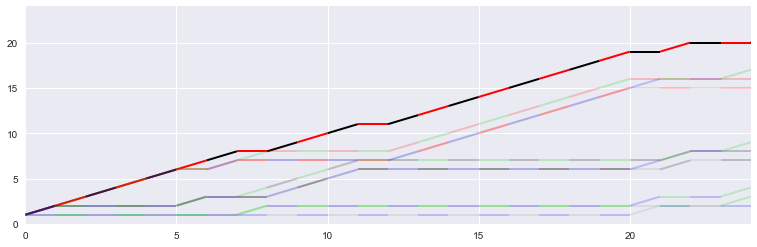

In [6]:
fig, ax = plt.subplots(figsize=(13, 4))

history_df = history_to_dataframe(drafter._archytype_preferences_history)

winning_archytype = history_df.max().idxmax()
winning_history = history_df.loc[:, winning_archytype]

colors = make_archytype_colors(winning_archytype, alpha=1.0)
plot_alternating_color_line(ax, winning_history.index.values, winning_history.values, colors)

for arch in set(history_df.columns) - set([winning_archytype]):
    arch_history = history_df.loc[:, arch]
    colors = make_archytype_colors(arch, alpha=0.2)
    plot_alternating_color_line(ax, arch_history.index.values, arch_history.values, colors)

    ax.set_xlim(0, 24)
ax.set_ylim(0, 24)

In [13]:
for card in drafter.cards:
    print(card['name'], ': ', card['colorIdentity'])

Brawl-Bash Ogre :  ['B', 'R']
Sarkhan's Whelp :  ['R']
Onakke Ogre :  ['R']
Sarkhan's Whelp :  ['R']
Tectonic Rift :  ['R']
Stitcher's Supplier :  ['B']
Electrify :  ['R']
Elvish Rejuvenator :  ['G']
Infectious Horror :  ['B']
Mind Rot :  ['B']
Infectious Horror :  ['B']
Skyscanner :  []
Goblin Motivator :  ['R']
Demanding Dragon :  ['R']
Tectonic Rift :  ['R']
Trumpet Blast :  ['R']
Banefire :  ['R']
Fiery Finish :  ['R']
Volley Veteran :  ['R']
Radiating Lightning :  ['R']
Cancel :  ['U']
Rise from the Grave :  ['B']
Transmogrifying Wand :  []
Reclamation Sage :  ['G']
Goblin Trashmaster :  ['R']
Stone Quarry :  ['R', 'W']
Inferno Hellion :  ['R']
Alpine Moon :  ['R']
Volley Veteran :  ['R']
Trumpet Blast :  ['R']
Rise from the Grave :  ['B']
Act of Treason :  ['R']
Plummet :  ['G']
Suspicious Bookcase :  []
Guttersnipe :  ['R']
Fountain of Renewal :  []
